In [1]:
pip install pandas pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kstest, norm
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import PowerTransformer
from scipy.stats import kruskal
from scipy.stats import chi2_contingency

# 차원 축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# 학습 모델 저장을 위한 라이브러리
import pickle

### 가설6 : Segment등급이 높을수록 실제 사용중인 카드 수도 많다.

In [9]:
# 데이터를 불러온다.
df1 = pd.read_parquet('open/train/1.회원정보/201807_train_회원정보.parquet')
df2 = pd.read_parquet('open/train/1.회원정보/201808_train_회원정보.parquet')
df3 = pd.read_parquet('open/train/1.회원정보/201809_train_회원정보.parquet')
df4 = pd.read_parquet('open/train/1.회원정보/201810_train_회원정보.parquet')
df5 = pd.read_parquet('open/train/1.회원정보/201811_train_회원정보.parquet')
df6 = pd.read_parquet('open/train/1.회원정보/201812_train_회원정보.parquet')

In [10]:
# 데이터 병합하기
# ignore_index = True : 인덱스를 새로 0부터 재부여한다.
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index = True)
# 처음과 마지막 5개 행 출력해서 확인하기
# print(train_df.head())
# print(train_df.tail())

In [11]:
# 필요한 컬럼 추출
df_g6 = df[['Segment', '이용카드수_신용']].dropna()
df_g6

,Segment,이용카드수_신용
0,D,1
1,E,1
2,C,1
3,D,1
4,E,0
...,...,...
2399995,E,0
2399996,D,1
2399997,C,1
2399998,E,0


### 정규성 확인을 위한 시각화 
 - Q-Q plot을 통한 시각화 진행

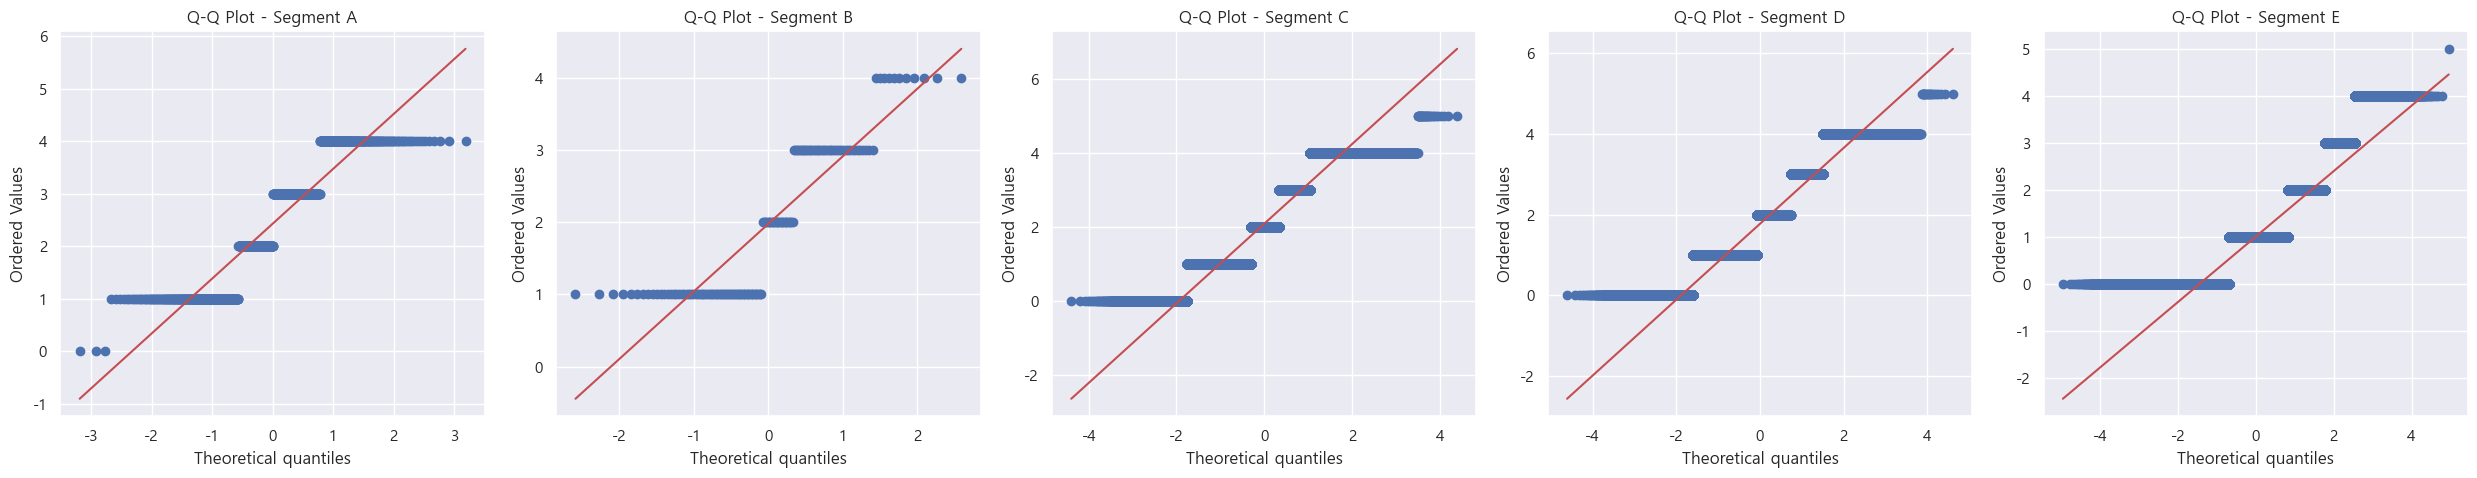

In [6]:
# Segment별 Q-Q Plot
segments = df_g6['Segment'].unique()
num_segments = len(segments)

plt.figure(figsize=(5 * num_segments, 5))

for i, seg in enumerate(sorted(segments)):
    plt.subplot(1, num_segments, i + 1)
    stats.probplot(
        df_g6[df_g6['Segment'] == seg]['이용카드수_신용'], 
        dist="norm", 
        plot=plt
    )
    plt.title(f"Q-Q Plot - Segment {seg}")

plt.tight_layout()
plt.show()

### 상관분석 
 - Q-Q plot을 통해 '이용카드수_신용'은 정규성을 위배한다는 결론이 나옴
 - 따라서 정규성 검정이 필요한 피어슨 상관분석보다는 Spearman 상관분석 진행

In [20]:
# 등급을 수치로 매핑 (예: A=5, ..., E=1)
segment_map = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
df_g6['Segment_score'] = df_g6['Segment'].map(segment_map)

# Spearman 상관분석
from scipy.stats import spearmanr
corr, p = spearmanr(df_g6['Segment_score'], df_g6['이용카드수_신용'])
print(f'Spearman 상관계수: {corr:.4f}, p-value: {p:.4f}')

Spearman 상관계수: 0.3426, p-value: 0.0000


### Krusakal-Wallis H-test
 - Segment 등급 간에 이용카드 수의 중앙값이나 분포 차이가 있는가?

In [14]:
# Segment별로 금액을 리스트로 분리
grouped_data = [
    df_g6[df_g6['Segment'] == seg]['이용카드수_신용'].dropna()
    for seg in sorted(df_g6['Segment'].unique())
]

In [15]:
# Kruskal-Wallis H-test 수행
stat, p = kruskal(*grouped_data)

# 결과값 출력
print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("→ 유의미한 차이가 있음. 귀무가설 기각됨")
else:
    print("→ 유의미한 차이가 없음. 귀무가설 채택.")

Kruskal-Wallis H-statistic: 281950.7895
p-value: 0.0000
→ 유의미한 차이가 있음. 귀무가설 기각됨


### 사후검정

In [17]:
import scikit_posthocs as sp

# 사후검정 실시
sp.posthoc_dunn(df_g6, val_col='이용카드수_신용', group_col='Segment', p_adjust='bonferroni')

,A,B,C,D,E
A,1.000000e+00,3.213828e-03,1.768081e-14,5.511538e-48,0.000000e+00
B,3.213828e-03,1.000000e+00,1.000000e+00,6.953753e-01,9.792257e-29
C,1.768081e-14,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
D,5.511538e-48,6.953753e-01,0.000000e+00,1.000000e+00,0.000000e+00
E,0.000000e+00,9.792257e-29,0.000000e+00,0.000000e+00,1.000000e+00


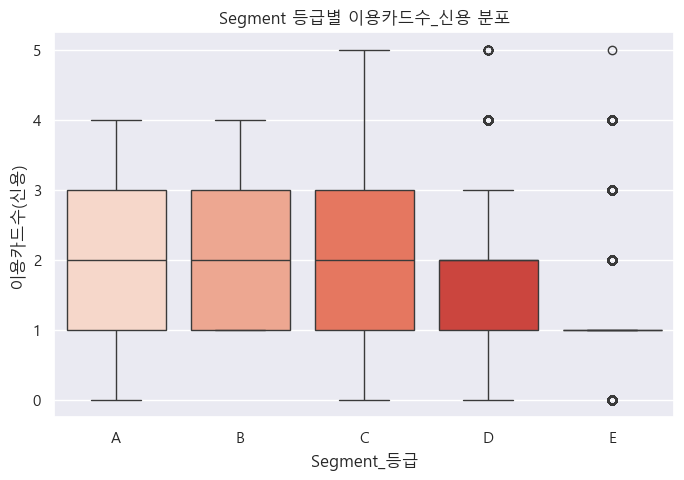

In [18]:
# Boxplot 시각화
plt.figure(figsize=(8, 5))
sns.boxplot(x='Segment', y='이용카드수_신용', data=df_g6, order=['A', 'B', 'C', 'D', 'E'], palette='Reds')
plt.title('Segment 등급별 이용카드수_신용 분포')
plt.ylabel('이용카드수(신용)')
plt.xlabel('Segment_등급')
plt.show()

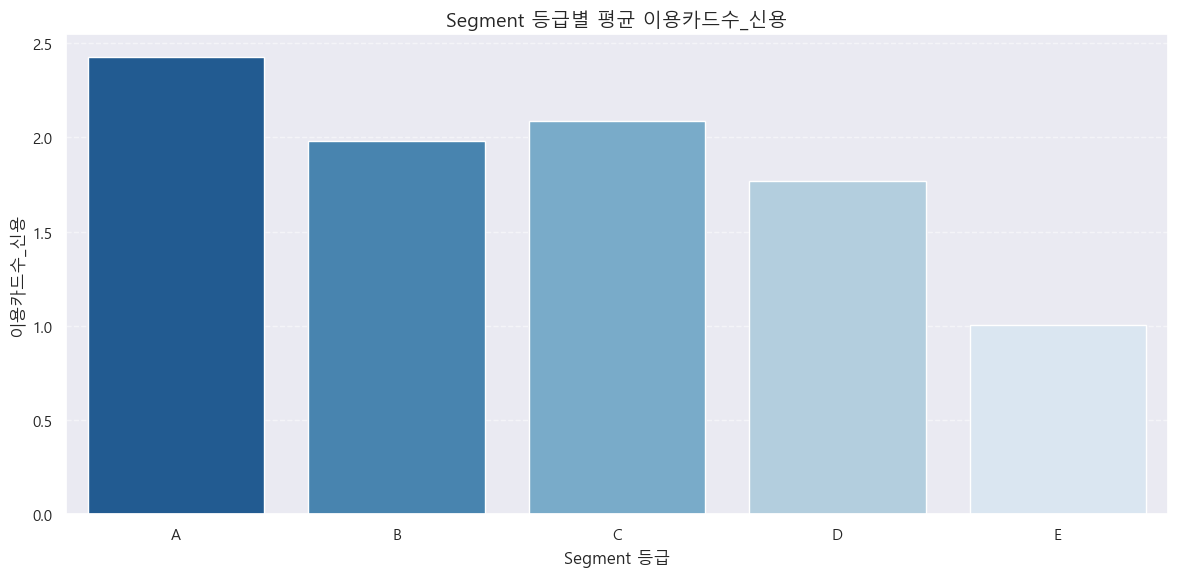

In [22]:
# Segment별 이용카드수_신용 bar plot
# 평균 이용카드수_신용
# A: 98294, B: 91296, C: 60613, D: 38603, E: 10054 
df_bar = df_g6.groupby('Segment')['이용카드수_신용'].mean().reset_index()
sns.barplot(x='Segment', y='이용카드수_신용', data=df_bar, palette='Blues_r')


plt.title('Segment 등급별 평균 이용카드수_신용', fontsize=14)
plt.xlabel('Segment 등급')
plt.ylabel('이용카드수_신용')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# 1. 수치형 변수만 선택
numeric_cols = ['이용가능카드수_신용', '이용카드수_신용']  # 원하는 컬럼 추가
X = df[numeric_cols].dropna()

# 2. 스케일링 (선택, 필수는 아님)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. VIF 계산
vif_df = pd.DataFrame()
vif_df['변수'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_df)

           변수       VIF
0  이용가능카드수_신용  3.768231
1    이용카드수_신용  3.768231
